# Drag Racing

In this task, you will design a nonlinear MPC controller to let the car travel as far as possible in positive $x$ direction in a fixed time interval.

The goal is to stay close to $y = 0$, while avoiding an obstacle at $x = 500, y = 0$.

We consider the car model with tire dynamics introduced in the lecture. 

The key to this problem is to use as much tire forces as possible, while ensuring that the car does not lose control. 

## 1. Car Dynamics

![CarModel](CarModel.png)

We consider the car dynamics with lumped rear and front tire forces. 

For simplicity, we consider the positions and orientation in the world coordinates.  

\begin{aligned}
\dot{U}_x & =\frac{F_{x_f} \cos \delta-F_{y_f} \sin \delta+F_{x_r}-F_d}{m}+r U_y \\
\dot{U}_y & =\frac{F_{y_f} \cos \delta+F_{x_f} \sin \delta+F_{y_r}+F_b}{m}-r U_x \\
\dot{r} & =\frac{a\left(F_{y_f} \cos \delta+F_{x_f} \sin \delta\right)-b F_{y_r}}{I_{z z}} \\
\dot{x} & = \cos(\phi)U_x - \sin(\phi)U_y  \\
\dot{y} & = \sin(\phi)U_x + \sin(\phi)U_y   \\ 
\dot{\phi} & =r  . \\
\end{aligned}


We consider the Euler first order integration to discretize the model. 

The actual control input of the vehicle is the traction force $F_w$ and steering angle $\delta$, which implicitly appears in the vehicle dynamics via the tire force $F_{x_f}$, $F_{y_f}$, $F_{x_r}$ and $F_{y_r}$. 

For more details of the **traction force model** and **tire force model**, please refer to the notebook of **Example - 4** and the **car simulator**.  

## 2. Model parameters

The following charts illustrate the model parameters, with actual values provided in **utils.py** in the **param** variable.

![Param](Param.png)


Laurense, V.A. and Gerdes, J.C., 2021. Long-horizon vehicle motion planning and control through serially cascaded model complexity. IEEE Transactions on Control Systems Technology, 30(1), pp.166-179.

## 3.  Modified tire model for control and optimization

The brush tire model saturated when the slip angle is greater than the threshold. Such saturated region will result in zero gradient, which is harmful for optimization. 

To solve the problem, we introduce the modified tire model for control, such that the tire forces will not saturated. 

We consider the modified maximal lateral tire force:
$$
\tilde{F}^{\max}_{y} = \sqrt{(\mu F_z)^2 - (0.99\tilde{F}_x)^2 }
$$
We here add an additional coefficient $0.99$ to avoid exceeding the firction limits. 

Then we introduce an variable $\xi$ and define the modified slide sliping angle:

$$
\alpha^{mod} = \arctan{\left( \frac{3F_y^{\max}\xi }{C_{\alpha}} \right)}. 
$$

Finally, we have the modified brush tire model for control:

\begin{aligned}
\tilde{F}_y&=\left\{\begin{array}{l}
-C_\alpha \tan \alpha
+\frac{C_\alpha^2}{3 \tilde{F}_y^{\max }}|\tan \alpha| \tan \alpha
-\frac{C_\alpha^3}{27\left(\tilde{F}_y^{\max }\right)^2} \tan ^3 \alpha
-C_\alpha\left(1-2 \xi+\xi^2\right) \tan \alpha \quad \text { if }|\alpha| \leq \alpha^{\bmod } \\

-\tilde{F}_y^{\max }\left(3 \xi^2-2 \xi^3\right) \operatorname{sgn} \alpha \quad \text { otherwise }
\end{array}\right. \\
& =\tilde{f}_{\text {tire }}\left(\alpha, F_z, F_x\right) \text {. } \\
&
\end{aligned}

We let $\xi$ be $0.85$ and provides the plot for comparison with the brush tire model. The dashed lines are the brush tire model without the modification. 


In [1157]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from utils import tire_model_sim, tire_model_ctrl, param

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Pranav Jain\AppData\Local\Temp\ipykernel_36592\3881750916.py:19: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(np.rad2deg(alpha), Fy / 1000, "g--", label = "$F_x = \mu F_z$")
C:\Users\Pranav Jain\AppData\Local\Temp\ipykernel_36592\3881750916.py:22: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(np.rad2deg(alpha), Fy / 1000, "g-", label = "$F_x = \mu F_z$ modified model")


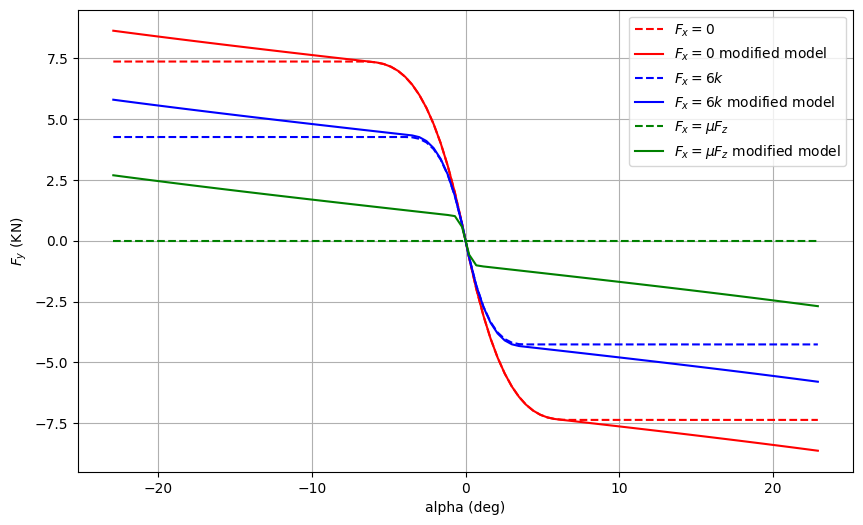

In [1158]:
Fx = 0.0
alpha = np.linspace(-0.4, 0.4, 100)

plt.figure(figsize=(10, 6))

Fy = tire_model_sim(alpha, 1000 * 9.81, 0, param["C_alpha_f"], param["mu_f"])
plt.plot(np.rad2deg(alpha), Fy / 1000, "r--", label = "$F_x = 0$")

Fy = tire_model_ctrl(alpha, 1000 * 9.81, 0, param["C_alpha_f"], param["mu_f"])
plt.plot(np.rad2deg(alpha), Fy / 1000, "r-",  label = "$F_x = 0$ modified model")

Fy = tire_model_sim(alpha, 1000 * 9.81, 6000, param["C_alpha_f"], param["mu_f"])
plt.plot(np.rad2deg(alpha), Fy / 1000, "b--", label = "$F_x = 6k$")

Fy = tire_model_ctrl(alpha, 1000 * 9.81, 6000, param["C_alpha_f"], param["mu_f"])
plt.plot(np.rad2deg(alpha), Fy / 1000, "b-",  label = "$F_x = 6k$ modified model")

Fy = tire_model_sim(alpha, 1000 * 9.81, 1000 * 9.81 * param["mu_f"], param["C_alpha_f"], param["mu_f"])
plt.plot(np.rad2deg(alpha), Fy / 1000, "g--", label = "$F_x = \mu F_z$")

Fy = tire_model_ctrl(alpha, 1000 * 9.81, 1000 * 9.81 * param["mu_f"], param["C_alpha_f"], param["mu_f"])
plt.plot(np.rad2deg(alpha), Fy / 1000, "g-", label = "$F_x = \mu F_z$ modified model")

plt.ylabel("$F_y$ (KN)")
plt.xlabel("alpha (deg)")
plt.legend()
plt.grid("on")

## 4.  Nonlinear Model Predictive Control

Let the state of the car be

$$
s_k:= \left[U_{x,k}, U_{y,k}, r_k, x_k, y_k, \phi_k \right], k = 0, 1, \dots, N. 
$$

Let the control input of the car be 

$$
u_k:= \left[ F_{x, k}, \delta_{k} \right], k = 0, 1, \dots, N-1.
$$

We introduce four auxiliary variable for each step:

$$
z_k:=\left[F_{y_f, k}, F_{y_r, k}, z_{\mu_f}, z_{\mu_r}\right], k = 0, 1, \dots, N-1.
$$

The first two variables will be used to enforce the tire force constraints, which means $F_{y_f, k}$ and $F_{y_r, k}$ will be explicit variables and related to traction force $F_x$ and steering angle $\delta$ via tire model. The last two variables ($z_{\mu_f}$ and $z_{\mu_r}$) will be used to slack the friction cone constraints.

The reason of introducing auxiliary variables is that more variable sometimes results in less nonlinearity. 

Thus the NMPC problem will take the form:

$$
    \begin{aligned}
    J_0^{*}(s_{init}) = \min_{s_k, u_k, z_k} & \ p(s_N) + \sum_{k=0}^{N-1} q(s_k, u_k, z_k)\\ 
    \text{s.t. } 
                %  & x_{k+1} =  \ k = 0, \dots, N-1, \\
                & s_{k+1} = f(s_k, u_k, z_k), k = 0, \dots, N-1, \\
                & 0=TireModel(s_k, u_k, z_k), \\
                & FrictionCone(s_k, z_k, u_k) \le 0, \\
                & OtherConstraints(s_k, z_k, u_k) \le 0, \\
                & u_{\min} \le u_k \le u_{\max}, \\
                & x_0 = x_{init}. 
    \end{aligned}
$$

## 5. Detail of constraints
### a. Friction cone constraints:

We introduce the slacked friction cone constraints:

$$ F_{y_f, k}^2 + F_{x_f, k}^2 \le (\mu_f F_{z_f, k})^2 + z_{\mu_f}^2  $$
$$ F_{y_r, k}^2 + F_{x_r, k}^2 \le (\mu_r F_{z_r, k})^2 + z_{\mu_r}^2  $$


### b. Obstacle avoidance:

The car should avoid colliding with the sphere obstacle:

$$ \left(\frac{x_k - 500}{10}\right)^2 + \left(\frac{y_k}{10}\right)^2 \ge 1  $$

### c. Input constraints:

Steering angle can not exceed the maximal value:
$$-\delta_{\max} \le \delta_k \le \delta_{\max}$$

Traction force can not exceed the engine power constraints:
$$ F_x \le \frac{P_{eng}}{U_x }$$

### d. Positive longitudinal speed

We do not want to drive in reverse:

$$ U_x \ge 2 $$

## 6.  Cost function design

Consider these goals when designing your cost function for each time-step:

### a. Stay close to the "lane"

Design a cost function to encourage the car to approach the lane: $y_k \rightarrow 0$. 

### b. Stabilize the yaw angle:

Design a cost function to encourage the car to maintain zero yaw angle: $\phi_k \rightarrow 0$. 

### c. Drive fast / far:

Design a cost function to encourage the car to drive as fast as possible, i.e. $U_x \rightarrow +\infty$ and $x \rightarrow +\infty$

### d. Avoid tire saturation:

Design a cost function to encourage the slip angle be smaller than the modified slip angle: 

$$
J_\alpha=W_\alpha \sum_{k=1}^N \begin{cases}\left(\left| \alpha_{k}\right|- \alpha_{k}^{\bmod }\right)^2, & \text { if }\left| \alpha_{k}\right| \geq \alpha_{k}^{\bmod } \\ 0, & \text { otherwise. }\end{cases}
$$

where $W_{\alpha}$ is a large weight. Add this cost using the **ca.if_else()** function. The $\alpha^{mod}$ is the modified slide slipping angle. 

### e. Penalize the slack variable of friction cone constraints:

Add a large weight to $z_{\mu_{f}}^2$ and $z_{\mu_{r}}^2$. 

## Submission

You are required to implement the controller on $2$ known test cases.

- Controller: Please complete the function **nmpc_controller()** in **nmpc_dragracing.py** and submit the file.
- Initial guess for warm-start:
  - Please submit the initial guess of the your NMPC solver for warm-start, i.e. the **\*.mat** files. You are supposed to compute it offline for as long as you wish until convergence. 
  - We have provided examples of initial guesses for the five test cases. However, you need to compute these **\*.mat** file based on your own controller.

## Evaluation

- We will evaluate the closed-loop trajectory based on the distance traveled in the $x$ direction and the deviation in $y$ direction. 
- Larger distance in $x$ direction and less deviation from $y$ will lead to higher score. 
- Collision with obstacle will result in large penalty.

## Remark

- In runtime, the NMPC is not required to converge to optimal value. We set **ipopt.max_iter=100** to ensure the simulation time is reasonable. The GSI code took less than $2$ minutes to complete the simulation for each test case. 

- As long as the NMPC is **feasible**, a suboptimal solution can still stabilize the system as long as the suboptimality is not too big. 

## FAQ

1. **How to start the assignment and reading materials?**

    Everything you need for the controller is given in the theory of this notebook. For precise conceptual clarity, it is also advised to look at the lecture notes and understand the relation between the code and the theory in this notebook.

2. **Why might the direct tire model calculations be preferred over auxiliary variables?**

    Direct tire model calculations can provide more precise force estimations but can make the optimization problem more complex and harder to solve efficiently due to increased nonlinearity. The tire model's lateral forces ensure physical accuracy aligning auxiliary variables with them

3. **How can I set up the cost function to keep the vehicle centered, aligned, and fast?**
    
    Think of the cost function as "guiding" the vehicle to stay on track: keep it near the center, aligned with the direction of the track, and close to a target speed. Penalize it when it drifts off-center, turns too much, or slows down. Refer to section [5] for a detailed mathematical formulation.

4. **Why am I getting an error that a variable (eg., $um$, $xm$, $zm$) is "free and not initialized"?**

    This error means a variable was used without being defined as an input in your CasADi function. Ensure all variables in your dynamics, constraints, or cost function are declared as inputs in ca.Function.

5. **Why do we use a warm start with an initial guess for the solver in the drag racing simulation?**

    A warm start with an initial guess helps the solver find an optimal solution more efficiently by starting it near a likely answer. Instead of starting from scratch, which can take longer, this approach leverages previously computed solutions to improve speed and stability in finding a solution, especially useful for complex or time-sensitive simulations like drag racing.

6. **I followed the setup, but the car’s behavior still seems off. What should I adjust?**

    Try tuning the weights for lateral deviation, speed target, and yaw stability. Small adjustments can help balance objectives and improve alignment with desired performance.

7.  **How should I incorporate x (distance traveled) in the stage cost for drag racing, and should the weight be linear or quadratic?**

    Rather than penalizing x in the cost, focus on achieving a high $v_{des}$ while maintaining the other constraints for lane keeping. Intuitively this ensures the high x constraint passively. 

8. **My Autograder is taking a lot of time to produce a score. What should I do?**

    Review and optimize your controller definition, focusing on simplifying calculations and refining equation formulations. This can help CasADi process more efficiently and reduce computation time. If it takes longer than 15 minutes, you may just need to resubmit, as the issue could then lie on the software side.

**NOTE** - Tuning the correct weights for the cost function (along with formulating it correctly) is very important!! Half of the problems may arise from there if everything is implemented correctly but the behaviour is still not as expected from the simulation.

    

## Code start

In [1159]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.io
import casadi as ca
from nmpc_dragracing import nmpc_controller

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Get an NMPC controller

In [1160]:
## build a controller 
prob, N_mpc, n_x, n_g, n_p, lb_var, ub_var, lb_cons, ub_cons = nmpc_controller(None)

### Compute the solution for initial condition

- To ensure that the autograder will converge in a reasonable time, we will use some initial conditions to warm start the solver.
- The testcases used in the autograder is provided in init_table, where each row is a test case.
- You are supposed to compute the solution of your NMPC controller for each initial conditions and save it as a **case_{index}.mat** file.
- Change *use_test_case* to 0 or 1. Only test one test case at a time.
- Start from one of the examples **case_{index}_example.mat** or random values. Once you have obtained the initial guess for one of the test cases, you can reuse it for other cases.

In [ ]:
## random initialization
x0_nlp    = np.random.randn(n_x, 1) * 0.025
lamx0_nlp = np.random.randn(n_x, 1) * 0.025
lamg0_nlp = np.random.randn(n_g, 1) * 0.025

# x0_nlp = np.random.randn(n_x, 1) * 0.1
# lamx0_nlp = np.zeros((n_x, 1))
# lamg0_nlp = np.zeros((n_g, 1))

## Once you have a solution, you can use it as initial guess for other cases
## initialization using known solution
# initial_guess = scipy.io.loadmat("case_0_example.mat")
# x0_nlp = initial_guess["x0_nlp"]
# lamx0_nlp = initial_guess["lamx0_nlp"]
# lamg0_nlp = initial_guess["lamg0_nlp"]

use_test_case = 1 # TODO: test one test case at a time
init_table = np.array([
    [50.0, 0.0, 0.0, 0.0, 0.0,  0.0],
    [30.0, 0.0, 0.0, 0.0, 50.0, 0.3],
])
init = init_table[use_test_case, :]
file_name = 'case_'+str(use_test_case)+'.mat'

## run sufficiently long time to ensure the solver converges to optimal value
opts = {'ipopt.max_iter':3000}

solver = ca.nlpsol('solver', 'ipopt', prob , opts)
sol = solver(x0=x0_nlp, lam_x0=lamx0_nlp, lam_g0=lamg0_nlp,
                     lbx=lb_var, ubx=ub_var, lbg=lb_cons, ubg=ub_cons, p=init)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      906
Number of nonzeros in inequality constraint Jacobian.:      322
Number of nonzeros in Lagrangian Hessian.............:      484

Total number of variables............................:      246
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      246
                     variables with only upper bounds:        0
Total number of equality constraints.................:      166
Total number of inequality constraints...............:      101
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      101
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -3.6840725e+03 4.46e+10 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

### Compare the solution after warm-start

You can find the solver is fast if the initial guess is properly provided. 

Save the initial guess for submission and your simulations. 

In [1162]:
## you will see how fast the solver is if it is initialized properly
x0_nlp    = sol["x"].full()
lamx0_nlp = sol["lam_x"].full()
lamg0_nlp = sol["lam_g"].full() # np.zeros((n_g, 1))
sol = solver(x0=x0_nlp, lam_x0=lamx0_nlp, lam_g0=lamg0_nlp,
                     lbx=lb_var, ubx=ub_var, lbg=lb_cons, ubg=ub_cons, p=init)

## save the initial guess if you are satisfied
scipy.io.savemat(file_name, {'x0_nlp': x0_nlp, "lamx0_nlp": lamx0_nlp, "lamg0_nlp": lamg0_nlp})

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      906
Number of nonzeros in inequality constraint Jacobian.:      322
Number of nonzeros in Lagrangian Hessian.............:      484

Total number of variables............................:      246
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      246
                     variables with only upper bounds:        0
Total number of equality constraints.................:      166
Total number of inequality constraints...............:      101
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      101
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -5.2083586e+05 9.67e+08 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [1163]:
## You can plot the solution here to see if it is reasonable. 

u = sol["x"].full()[0:N_mpc * 2]
x = sol["x"].full()[N_mpc * 2:N_mpc * 2 + (N_mpc + 1) * 6]

### Retrieve the initial solutions for simulation. 

If you already have the initial solutions, you can start from this block to retrieve them. 

In [1164]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.io
from utils import plot_results
from sim import GetCarModel, SimVehicle
from nmpc_dragracing import nmpc_controller

## test the controller with different inirial states and guesses
# use_test_case = 1 # TODO: test one test case at a time
init_table = np.array([
    [50.0, 0.0, 0.0, 0.0, 0.0,  0.0],
    [30.0, 0.0, 0.0, 0.0, 50.0, 0.3],
])
init = init_table[use_test_case, :]
file_name = 'case_'+str(use_test_case)+'.mat'

initial_guess = scipy.io.loadmat(file_name)
x0_nlp = initial_guess["x0_nlp"]
lamx0_nlp = initial_guess["lamx0_nlp"]
lamg0_nlp = initial_guess["lamg0_nlp"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Simulation start! 

We will simulate the vehicle for 30 secs. 

As we are using fixed-step RK simulator and limits the maximal iteration for IPOPT, the simulation time is controllable. 

In [1165]:
## build a car simulator
## The car will be driving for 30 secs
## The control rate is 10 HZ.
T_sim  = 30
dt_ctrl = 0.1
rk_interval = 10
N_sim = int(np.ceil(T_sim / dt_ctrl))
integrator, car_dynamics = GetCarModel(None, ts = np.linspace(0, dt_ctrl, rk_interval), ode = "rk")
sim_time = np.linspace(0, T_sim, N_sim * (rk_interval - 1) + 1)

In [1166]:
y0 = np.reshape(init, (6, 1))
is_silent = True # change this to False if you want to see all errors and warnings
x_log, u_log, tire_force_log = SimVehicle(y0, nmpc_controller, integrator, car_dynamics, N_sim, True, x0_nlp, lamx0_nlp, lamg0_nlp, is_silent)

Simulation completed. Spend 63.387531 secs


### Trajectory

You are supposed to avoid the obstacle, while trying to keep $y = 0$ and reach larger $x$. 

In [1167]:
print("Distance traveled in x direction:")
print(np.max(x_log[3, :]))

print("Deviation in y direction:")
print(np.sqrt(np.mean(x_log[4,:]**2)))

Distance traveled in x direction:
1771.1110414801478
Deviation in y direction:
4.610053227732859


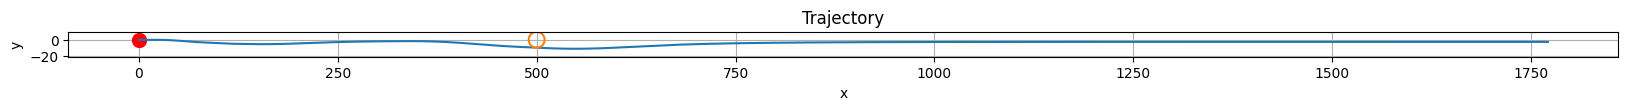

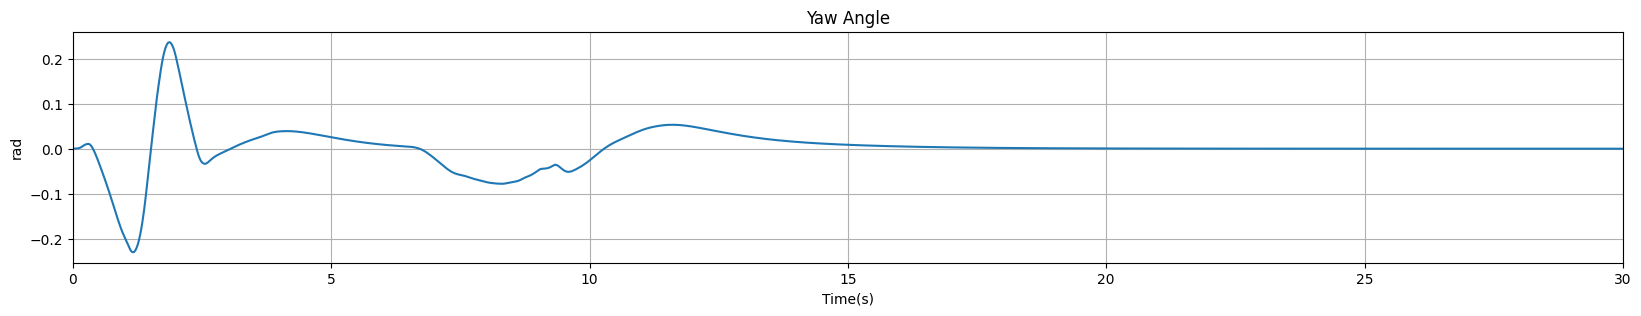

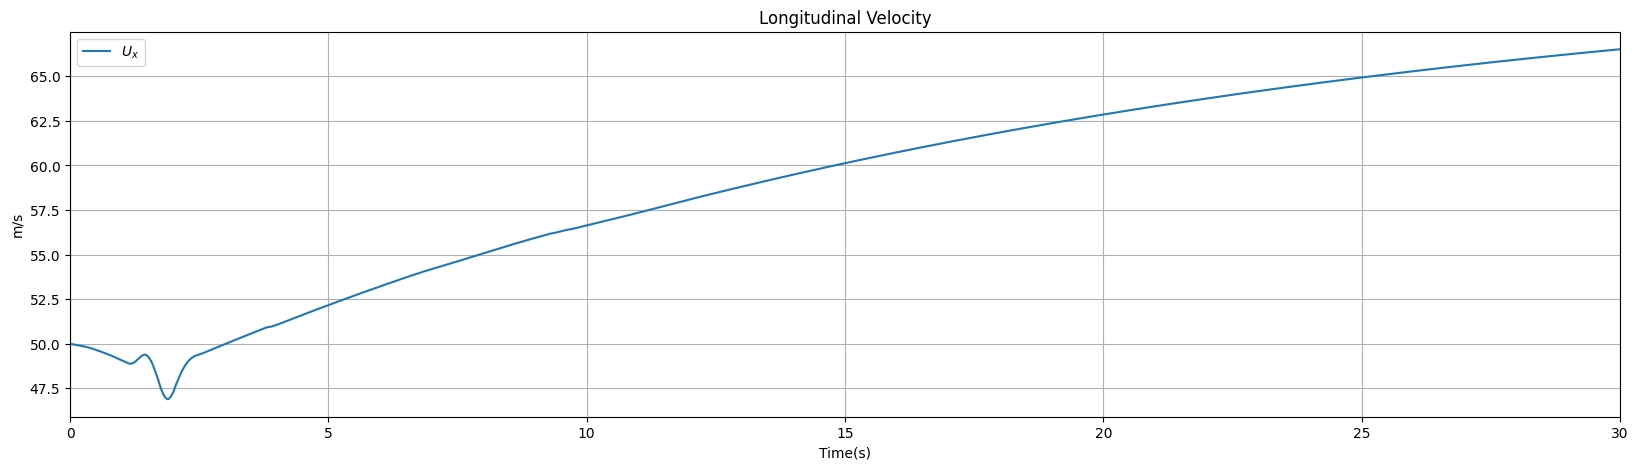

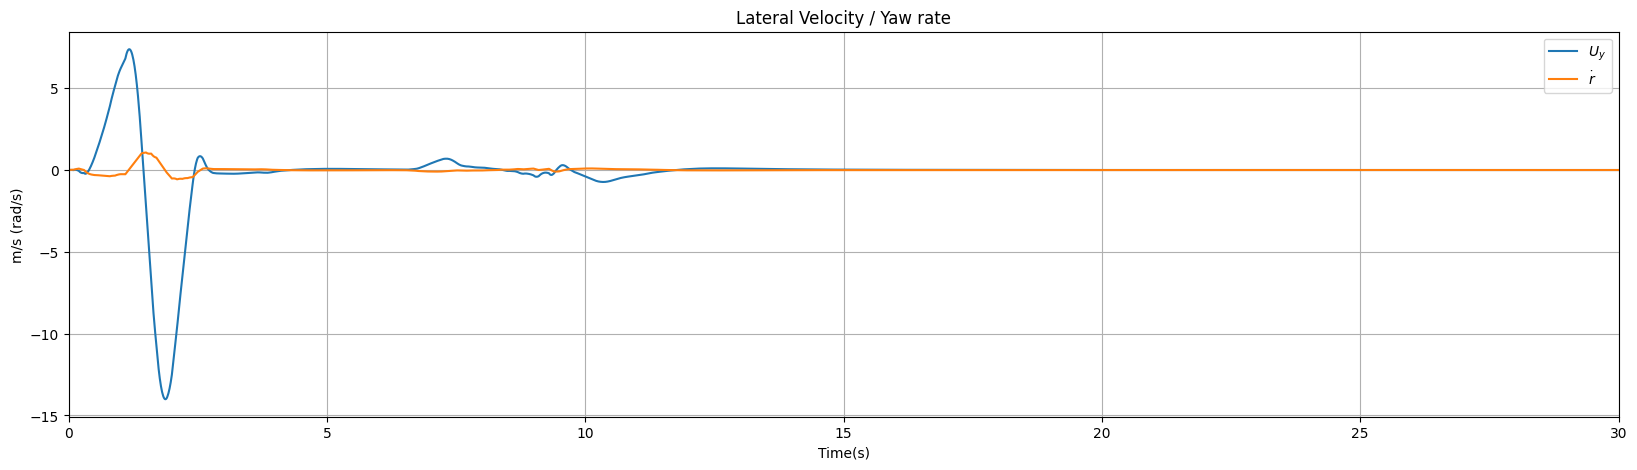

The traction force will decrease due to the engine power limits when the velocity is large.


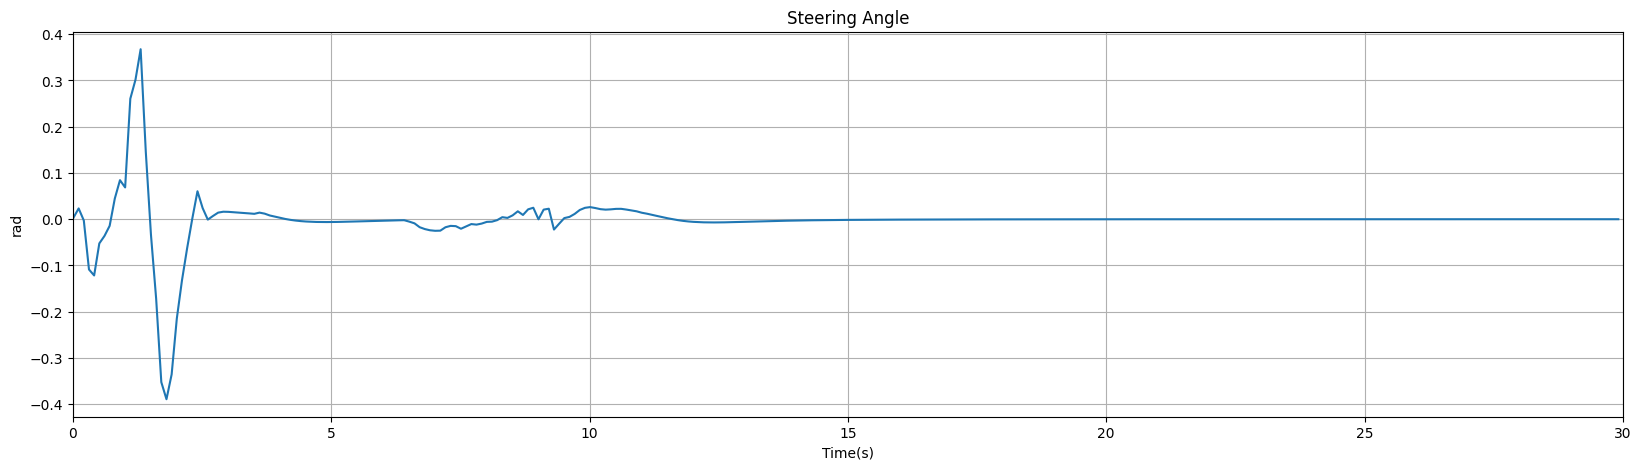

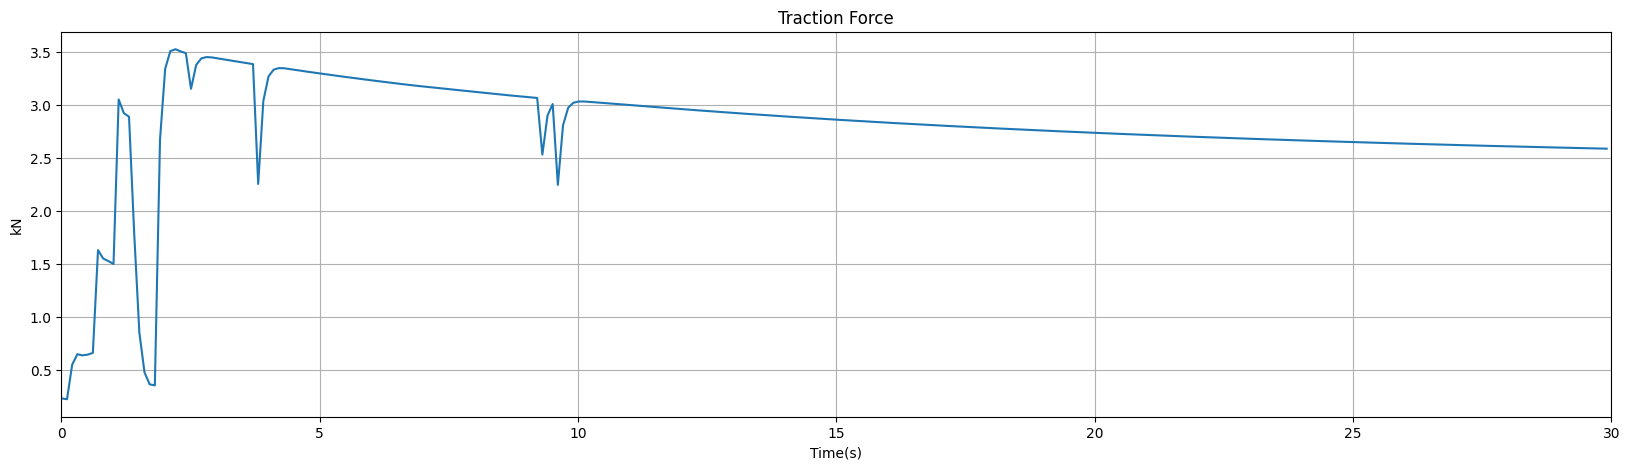

For successful trial, the tire forces should be distributed at the boundary of the friction cone to achieve maximum acceleration and braking. This behavior is similar to real-world drag racing.


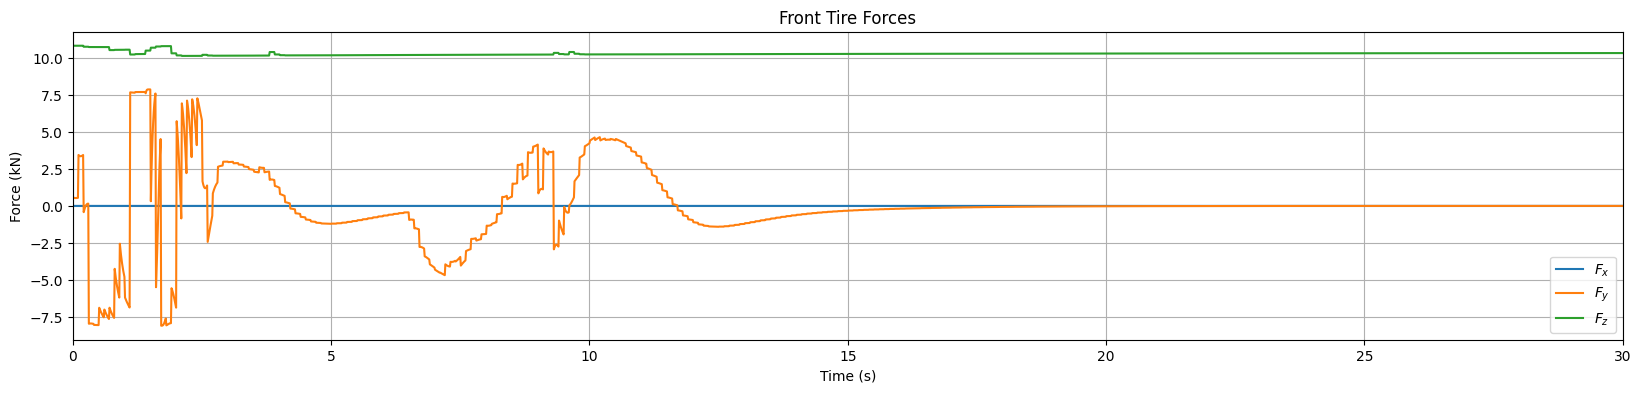

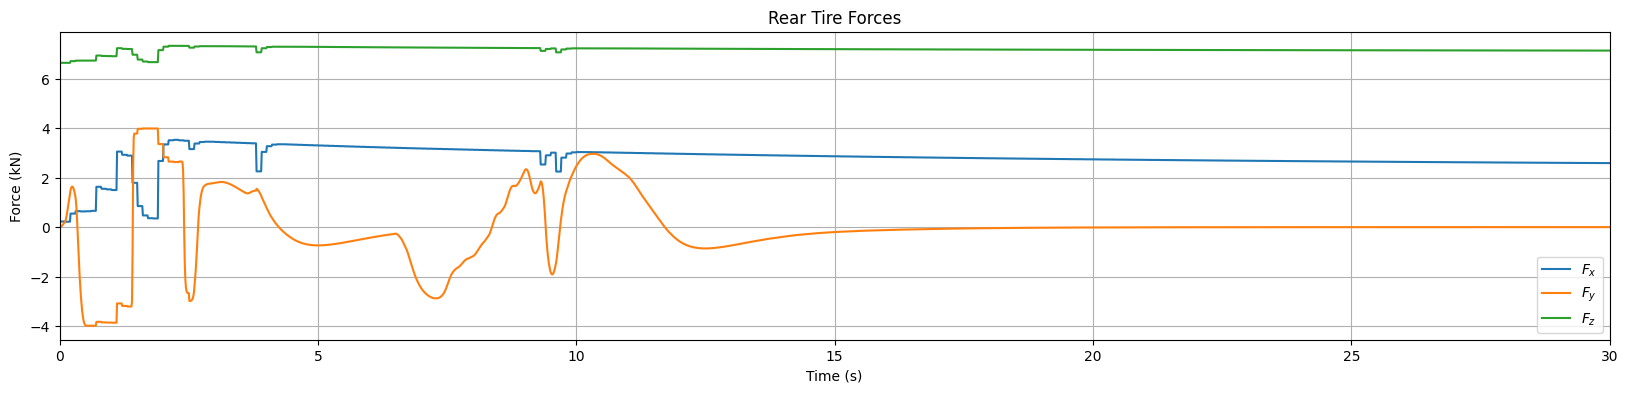

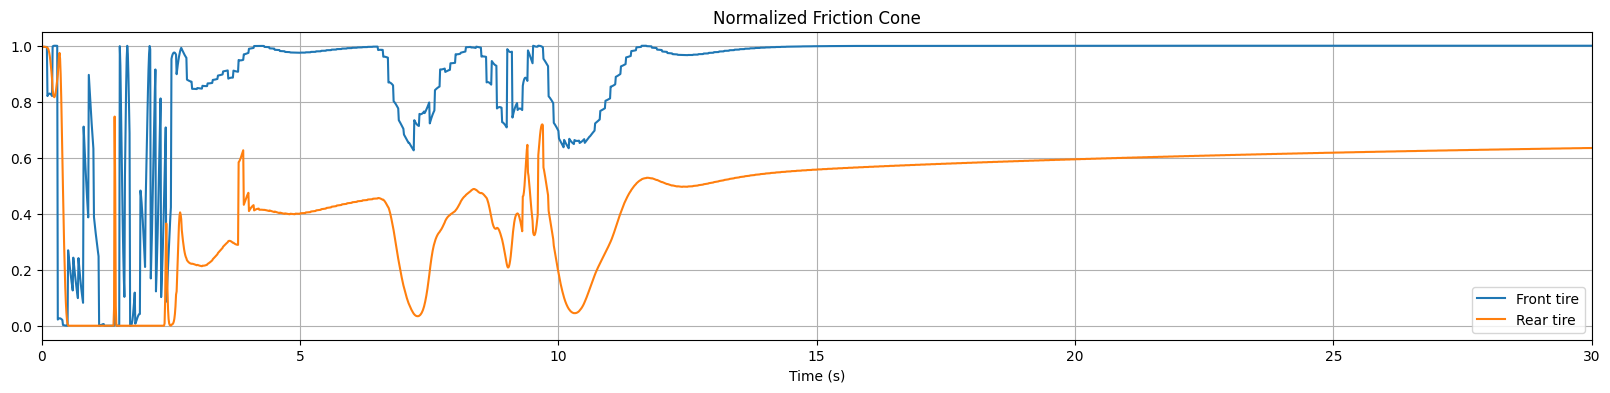

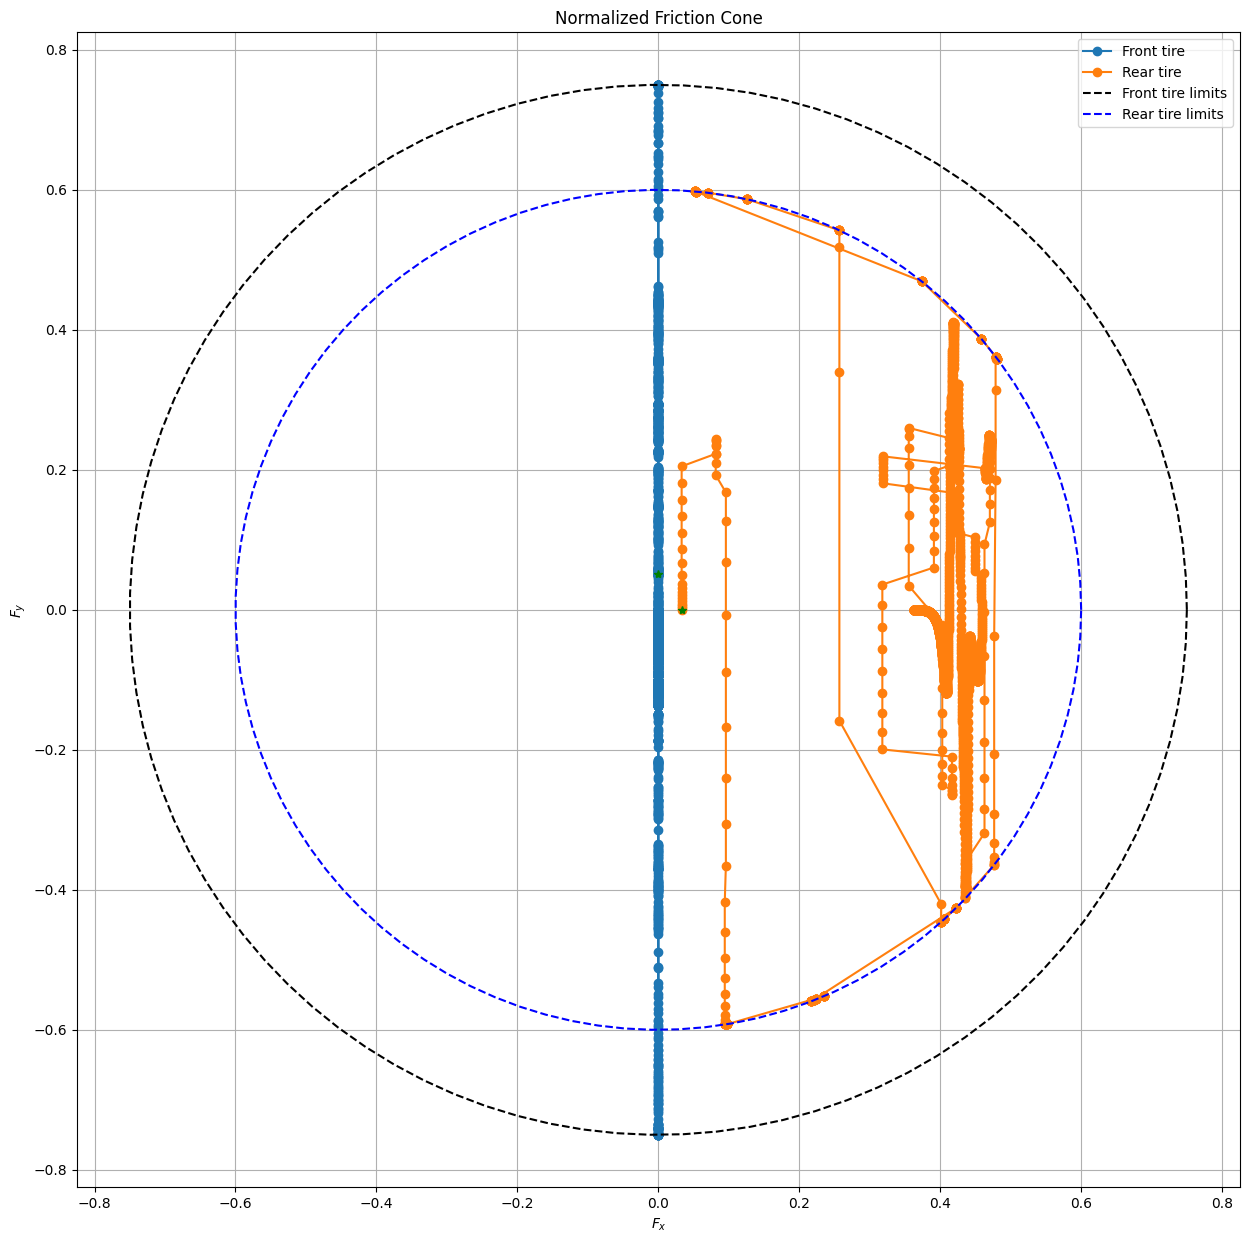

In [1168]:
plot_results(T_sim, sim_time, x_log, u_log, tire_force_log)